we will use a real dataset of anonymized credit card transactions
made by European cardholders from September 2013. These transactions are
labeled as fraudulent or genuine, and we will build a fraud detection solution
using machine learning to predict the correct labels for never-before-seen
instances

In [1]:
import numpy as np
import pandas as pd
import os

#  --Viz--
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

#  --Data Preparation--
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

#  --Algorithms--
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [2]:
file = "D:\\Unsupervised\\handson-unsupervised-learning\\datasets\\credit_card_data\\creditcard.csv"
data = pd.read_csv(file)

In [3]:
data.shape

(284807, 31)

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
# searching for missing values
np.isnan(data).sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
# Identify distinct values by feature
data.apply(lambda x: len(x.unique()))

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

we can see there are many transactions happened in the same time

## Data Preprocessing 

In [9]:
#make copy from data
dataX = data.copy().drop(["Class"],axis=1)
dataY = data["Class"].copy()

In [10]:
# specify the features needed to be scaled and apply StandardScaler to make all data with mean 0 and std 1
featuresToScale = dataX.drop("Time",axis=1).columns
scaler = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = scaler.fit_transform(dataX[featuresToScale])

In [11]:
dataX.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.0,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,1.0,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,1.0,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,2.0,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


## Data Vizualization 

<AxesSubplot:>

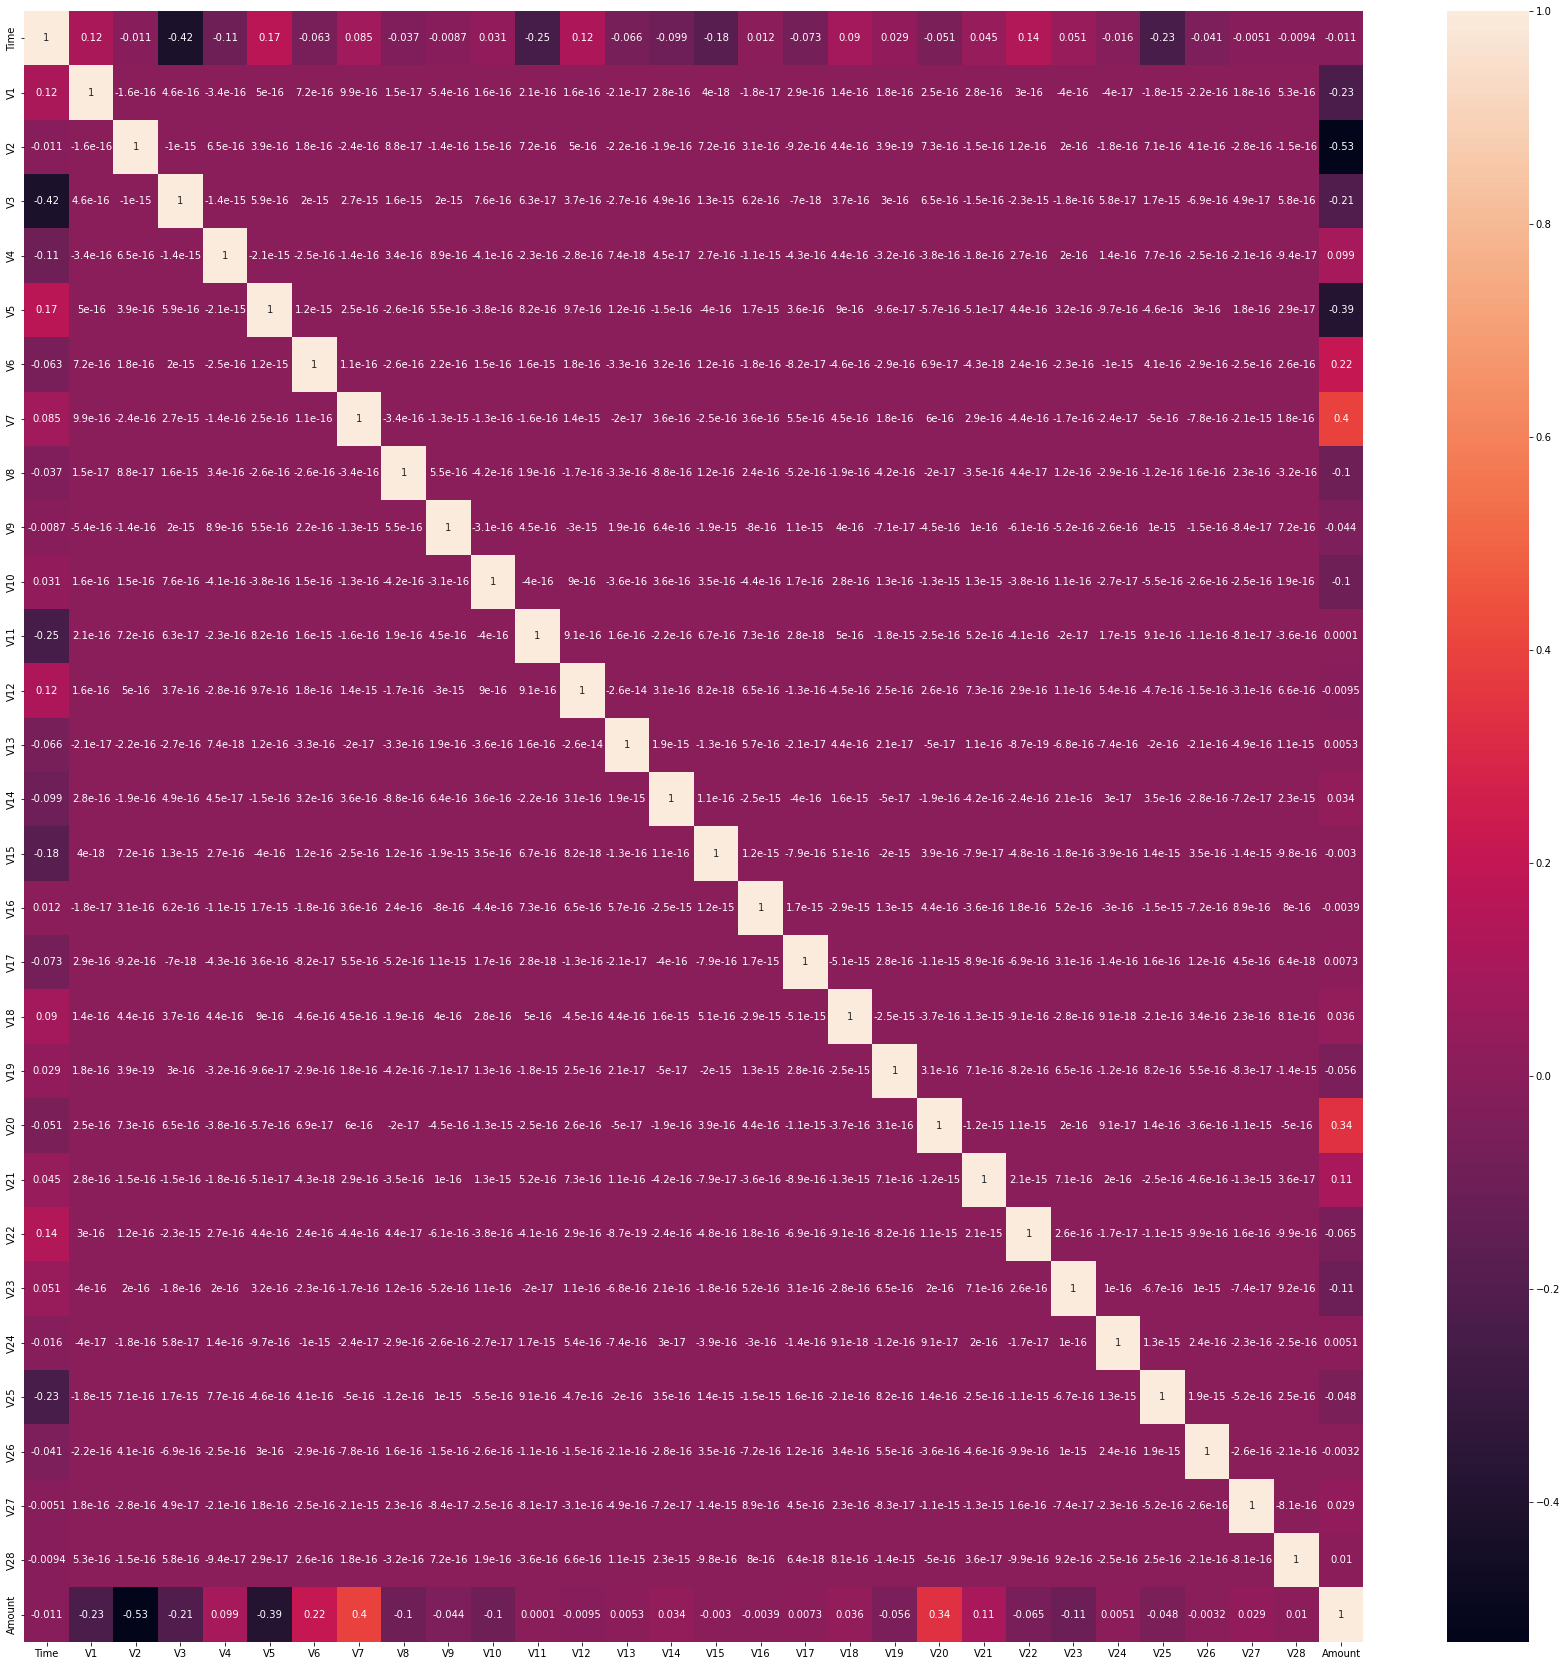

In [62]:
plt.figure(figsize=(30,30))
sns.heatmap(dataX.corr(),annot=True)

we can see that there aren't any correlated features as they applied pca on the data

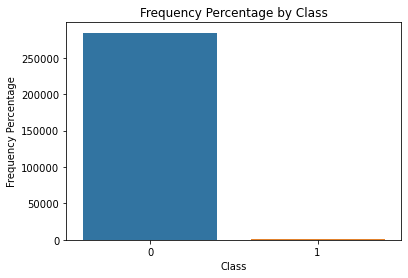

In [13]:
fig , ax = plt.subplots()
sns.barplot(x=data['Class'].value_counts().index,y = data['Class'].value_counts())
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')
plt.show();

we can see that the data is impalanced

## Model Preparation

In [14]:
#split data into train and test so we can evaluate our model
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=42, stratify=dataY)

In [15]:
#split data into 5 folds so we can evaluate model while training
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Machine Learning Models

### Model 1:Logistic Regression

In [16]:
# hyperparameters
penalty = 'l2' #Regulaization technique
C = 1.0 #default
class_weight = 'balanced' #because the data is impalanced
random_state = 42
solver = 'liblinear' #better for binary classification
logReg = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, random_state=random_state,\
                            solver=solver, n_jobs=1)

In [17]:
#training
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, columns=[0,1])
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)) ,y_train.ravel()):
    
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    logReg.fit(X_train_fold, y_train_fold)
    
    loglossTraining = log_loss(y_train_fold, logReg.predict_proba(X_train_fold)[:,1])
    
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = logReg.predict_proba(X_cv_fold)
    
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
       
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.10007975639746543
CV Log Loss:  0.10460575600429291
Training Log Loss:  0.09001054735769426
CV Log Loss:  0.08699093736349445
Training Log Loss:  0.09186119402778208
CV Log Loss:  0.09076909773396619
Training Log Loss:  0.09379857246200511
CV Log Loss:  0.09566553120745484
Training Log Loss:  0.0968911260612839
CV Log Loss:  0.09691904139274077
Logistic Regression Log Loss:  0.09499007274038984


we evaluate the model we precision and recall curve and AUROC curve

In [18]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsRandomForests = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'], preds['prediction'])

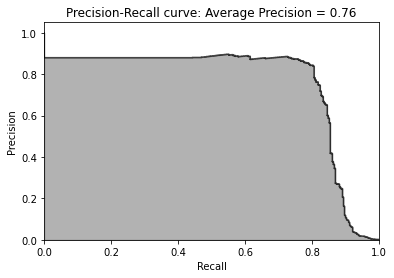

In [19]:
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))
plt.show();

we can notice that we 80% of recall we can get 70% of precision

still it is business wise

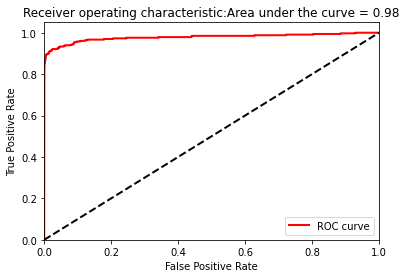

In [20]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic:Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

### Model 2: Random Forests 

In [58]:
#we can use gridsearch to tune hyperparameters
n_estimators = 100
n_jobs = -1
max_depth = 6
random_state = 42
class_weight = 'balanced'
RFC = RandomForestClassifier(n_estimators = n_estimators,n_jobs = n_jobs,random_state = random_state, max_depth = max_depth,
                             class_weight = class_weight)

In [59]:
#training
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, columns=[0,1])
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)) ,y_train.ravel()):
    
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    RFC.fit(X_train_fold, y_train_fold)
    
    loglossTraining = log_loss(y_train_fold, RFC.predict_proba(X_train_fold)[:,1])
    
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = RFC.predict_proba(X_cv_fold)
    
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
       
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])
print('Random Forest Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.04856644013845889
CV Log Loss:  0.04958283293957184
Training Log Loss:  0.04446603717191198
CV Log Loss:  0.04417452364925594
Training Log Loss:  0.04147415905336449
CV Log Loss:  0.04177951640010606
Training Log Loss:  0.04490911779481459
CV Log Loss:  0.04593513570823381
Training Log Loss:  0.04625065786586719
CV Log Loss:  0.04711764111632439
Random Forest Log Loss:  0.045717929962698405


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.79')

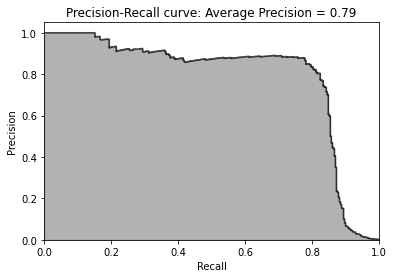

In [60]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsRandomForests = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

with 80% of recall we can get about 90% of precision

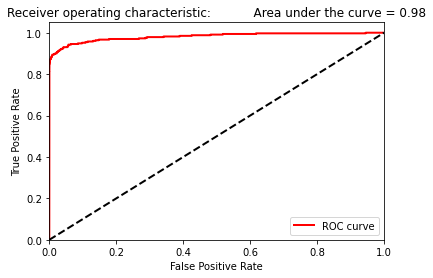

In [61]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
          Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

### Model 3: Gradient Boosting Machine (XGBoost) 

In [27]:
params_xGB = {
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'seed':42,
    'verbosity':1
}

In [28]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
    dCV = xgb.DMatrix(data=X_cv_fold)
    
    bst = xgb.cv(params_xGB, dtrain, num_boost_round=2000, nfold=5, early_stopping_rounds=200, verbose_eval=50)
    
    best_rounds = np.argmin(bst['test-logloss-mean'])
    bst = xgb.train(params_xGB, dtrain, best_rounds)
    
    loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = bst.predict(dCV)
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossXGBoostGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('XGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)

[0]	train-logloss:0.43795+0.00004	test-logloss:0.43807+0.00006
[50]	train-logloss:0.00014+0.00001	test-logloss:0.00306+0.00094
[100]	train-logloss:0.00006+0.00000	test-logloss:0.00336+0.00108
[150]	train-logloss:0.00004+0.00000	test-logloss:0.00347+0.00113
[200]	train-logloss:0.00004+0.00000	test-logloss:0.00354+0.00115
[230]	train-logloss:0.00003+0.00000	test-logloss:0.00357+0.00116
Training Log Loss:  0.0006429777506755244
CV Log Loss:  0.002203896730335659
[0]	train-logloss:0.43794+0.00003	test-logloss:0.43805+0.00006
[50]	train-logloss:0.00013+0.00000	test-logloss:0.00294+0.00067
[100]	train-logloss:0.00006+0.00000	test-logloss:0.00314+0.00071
[150]	train-logloss:0.00004+0.00000	test-logloss:0.00324+0.00074
[200]	train-logloss:0.00004+0.00000	test-logloss:0.00330+0.00076
[229]	train-logloss:0.00003+0.00000	test-logloss:0.00332+0.00077
Training Log Loss:  0.0006082256878820796
CV Log Loss:  0.0024250213477355295
[0]	train-logloss:0.43790+0.00001	test-logloss:0.43802+0.00008
[50]	tra

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.84')

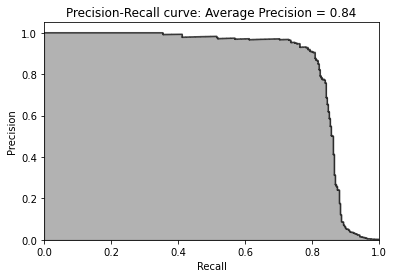

In [31]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsXGBoost = preds.copy()

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

with 80% of recall we can get about 90% of precision and this is the best classifier 

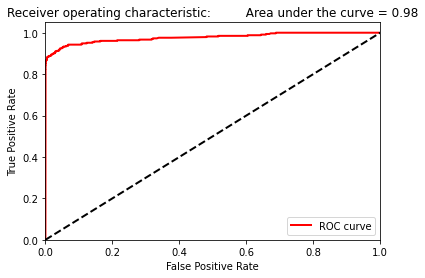

In [32]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
        Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

## Evaluation

In [54]:
predictionsTestSetLogisticRegression = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:,'prediction'] = logReg.predict_proba(X_test)[:,1]
logLossTestSetLogisticRegression = log_loss(y_test, predictionsTestSetLogisticRegression)
print("Log Loss of Logistic Regression on Test Set: ", logLossTestSetLogisticRegression)

predictionsTestSetRandomForests = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetRandomForests.loc[:,'prediction'] = RFC.predict_proba(X_test)[:,1]
logLossTestSetRandomForests = log_loss(y_test, predictionsTestSetRandomForests)
print("Log Loss of Random Forests on Test Set: ", logLossTestSetRandomForests)

predictionsTestSetXGBoost = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
dtest = xgb.DMatrix(data=X_test)
predictionsTestSetXGBoost.loc[:,'prediction'] = bst.predict(dtest)
logLossTestSetXGBoost = log_loss(y_test, predictionsTestSetXGBoost)
print("Log Loss of XGBoost Gradient Boosting on Test Set: ", logLossTestSetXGBoost)

Log Loss of Logistic Regression on Test Set:  0.09882171876250319
Log Loss of Random Forests on Test Set:  0.053064802506933385
Log Loss of XGBoost Gradient Boosting on Test Set:  0.00280571827089699


we can see that XGBoost is the best classifier without fine tuning any parameters

Text(0.5, 1.0, 'Plot of Prediction Probabilities and the True Label')

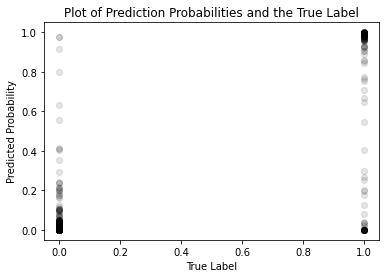

In [57]:
scatterData = predictionsTestSetXGBoost.join(y_test,how='left')
scatterData.columns = ['Predicted Probability','True Label']
ax = sns.regplot(x="True Label", y="Predicted Probability", color='k', fit_reg=False,scatter_kws={'alpha':0.1}, data=scatterData)
ax.set_title('Plot of Prediction Probabilities and the True Label')

Text(0.5, 1.0, 'Plot of Prediction Probabilities and the True Label')

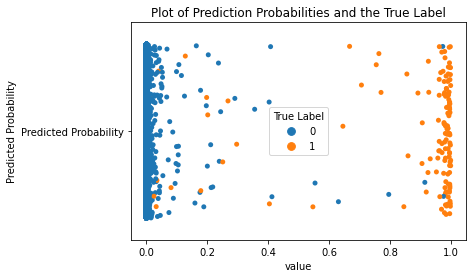

In [56]:
scatterDataMelted = pd.melt(scatterData, "True Label", var_name="Predicted Probability")
ax = sns.stripplot(x="value", y="Predicted Probability", hue='True Label', jitter=0.4, data=scatterDataMelted)
ax.set_title('Plot of Prediction Probabilities and the True Label')